In [1]:
from ridge_regression_analysis import train_ridge_regression, train_one_step_cross_validation, single_cross_validation, model_cross_validation, all_models_cross_validation

import pickle
import os 
import netCDF4 as netcdf
import skimage
import numpy as np
import torch 

with open('ssp585_time_series.pkl', 'rb') as f:
    dic_ssp585 = pickle.load(f)

# Get the list of all files and directories
path = "/net/atmos/data/cmip6-ng/tos/ann/g025"
dir_list = os.listdir(path)

print("Files and directories in '", path, "' :")

list_model = []
list_forcing = []

for idx, file in enumerate(dir_list):

    file_split = file.split("_")
    
    # extract model names
    model_name = file_split[2]
    forcing = file_split[3]
    run_name = file_split[4]
    
    list_model.append(model_name)
    list_forcing.append(forcing)
    
model_names = list(set(list_model))
forcing_names = list(set(list_forcing))


# define the file
file = '/net/h2o/climphys3/simondi/cope-analysis/data/erss/sst_annual_g050_mean_19812014_centered.nc'

# read the dataset
file2read = netcdf.Dataset(file,'r')

# load longitude, latitude and sst monthly means
lon = np.array(file2read.variables['lon'][:])
lat = np.array(file2read.variables['lat'][:])
sst = np.array(file2read.variables['sst'])

# define grid
lat_grid, lon_grid = np.meshgrid(lat, lon, indexing='ij')

time_period = 33
grid_lat_size = lat.shape[0]
grid_lon_size = lon.shape[0]

# first filter out the models that do not contain ensemble members 
dic_reduced_ssp585 = {}

for m in list(dic_ssp585.keys()):
    if len(dic_ssp585[m].keys()) > 2:
        dic_reduced_ssp585[m] = dic_ssp585[m].copy()
        for idx_i, i in enumerate(dic_ssp585[m].keys()):
            dic_reduced_ssp585[m][i] = skimage.transform.downscale_local_mean(dic_reduced_ssp585[m][i],(1,2,2))
            lat_size = dic_reduced_ssp585[m][i][0,:,:].shape[0]
            lon_size = dic_reduced_ssp585[m][i][0,:,:].shape[1]

######## Store Nan indices 

nan_idx = []
for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    for idx_i,i in enumerate(dic_reduced_ssp585[m].keys()):    

        nan_idx_tmp = list(np.where(np.isnan(dic_reduced_ssp585[m][i][0,:,:].ravel())==True)[0])        
        nan_idx = list(set(nan_idx) | set(nan_idx_tmp))

notnan_idx = list(set(list(range(lon_size*lat_size))) - set(nan_idx))

############################


# second, for each model we compute the anomalies 
dic_processed_ssp585 = {}

import numpy as np

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_processed_ssp585[m] = dic_reduced_ssp585[m].copy()
    
    mean_ref_ensemble = 0
    for idx_i, i in enumerate(dic_reduced_ssp585[m].keys()):
        y_tmp = dic_reduced_ssp585[m][i][131:164,:,:].copy().reshape(time_period, lat_size*lon_size)
        y_tmp[:,nan_idx] = float('nan')

        if idx_i == 0:
            mean_ref_ensemble = np.nanmean(y_tmp,axis=0)/ len(dic_processed_ssp585[m].keys())
        else:
            mean_ref_ensemble += np.nanmean(y_tmp,axis=0)/ len(dic_processed_ssp585[m].keys())

    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
        dic_processed_ssp585[m][i] = y_tmp - mean_ref_ensemble


# compute the forced response
dic_forced_response_ssp585 = dict({})

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_forced_response_ssp585[m] = dic_reduced_ssp585[m].copy()

    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        
        y_tmp = dic_reduced_ssp585[m][i][131:164,:,:].copy().reshape(time_period, lat_size*lon_size)
        y_tmp[:,nan_idx] = float('nan')
        
        if idx_i == 0:
            mean_spatial_ensemble = np.nanmean(y_tmp,axis=1)/ len(dic_forced_response_ssp585[m].keys())
        else:
            mean_spatial_ensemble += np.nanmean(y_tmp,axis=1)/ len(dic_forced_response_ssp585[m].keys())

    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):        
        dic_forced_response_ssp585[m][i] = mean_spatial_ensemble - np.nanmean(mean_spatial_ensemble)

y_forced_response = {}
x_predictor = {}

for idx_m,m in enumerate(dic_processed_ssp585.keys()):
    y_forced_response[m] = {}
    x_predictor[m] = {}

    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):       
        y_forced_response[m][i] = dic_forced_response_ssp585[m][i]
        x_predictor[m][i] = dic_processed_ssp585[m][i]
        x_predictor[m][i][:,nan_idx] = float('nan')


# compute the variance
variance_processed_ssp585 = {}
std_processed_ssp585 = {}
for idx_m,m in enumerate(x_predictor.keys()):
    variance_processed_ssp585[m] = {}
    arr_tmp = np.zeros((len(x_predictor[m].keys()),33))
    
    for idx_i, i in enumerate(list(x_predictor[m].keys())):
        arr_tmp[idx_i,:] = np.nanmean(x_predictor[m][i],axis=1)

    arr_tmp_values = np.zeros((len(x_predictor[m].keys()),33))
    for idx_i, i in enumerate(x_predictor[m].keys()):
        arr_tmp_values[idx_i,:] = (y_forced_response[m][i] - arr_tmp[idx_i,:])**2

    variance_processed_ssp585[m] = torch.nanmean(torch.from_numpy(arr_tmp_values),axis=0)

Files and directories in ' /net/atmos/data/cmip6-ng/tos/ann/g025 ' :


/tmp/ipykernel_18123/2354485694.py:95: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble = np.nanmean(y_tmp,axis=0)/ len(dic_processed_ssp585[m].keys())
/tmp/ipykernel_18123/2354485694.py:97: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble += np.nanmean(y_tmp,axis=0)/ len(dic_processed_ssp585[m].keys())


In [44]:
grid_lat_size*grid_lon_size - len(nan_idx)

1521

In [2]:
# Data preprocessing
x_train = {}
y_train = {}

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    x_train[m] = {}
    y_train[m] = {}
    
    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
    
        x_train[m][i] = torch.from_numpy(np.nan_to_num(x_predictor[m][i])).to(torch.float64)
        y_train[m][i] = torch.from_numpy(np.nan_to_num(y_forced_response[m][i])).to(torch.float64)

# Load ERA5 data

In [3]:
import netCDF4 as netcdf

# define the file
file = '/net/h2o/climphys3/simondi/cope-analysis/data/erss/sst_annual_g050_mean_19812014_centered.nc'

# read the dataset
file2read = netcdf.Dataset(file,'r')

# load longitude, latitude and sst monthly means
lon = np.array(file2read.variables['lon'][:])
lat = np.array(file2read.variables['lat'][:])
sst = np.array(file2read.variables['sst'])

# define grid
lat_grid, lon_grid = np.meshgrid(lat, lon, indexing='ij')

# Read results

In [4]:
# read robust regression files
file = open('results/betas_ridge_individual.pkl', 'rb')
betas = pickle.load(file)
file.close()

file = open('results/rmse_ridge_individual.pkl', 'rb')
rmse = pickle.load(file)
file.close()

# Plot the residuals

In [40]:
###### Compute residual ##########
sst_tmp = sst[131:164,:,:].reshape((33,lon.shape[0]*lat.shape[0])).copy()
sst_tmp[np.abs(sst_tmp)> 1e20] = float('nan')
ytrue = np.nanmean(sst_tmp,axis=1)

lambda_ = 0.01


# for each model, compute the predicted values 
ypred = {}
sst_tmp_zeros = sst[131:164,:,:].reshape((33,lon.shape[0]*lat.shape[0])).copy()
sst_tmp_zeros[np.abs(sst_tmp_zeros)> 1e20] = 0.0

for idx_m, m in enumerate(x_predictor.keys()):
    beta_tmp = np.nanmean(np.array(list(betas[m][0.01].values())),axis=0)
    ypred[m] = np.matmul(beta_tmp,sst_tmp_zeros.T)

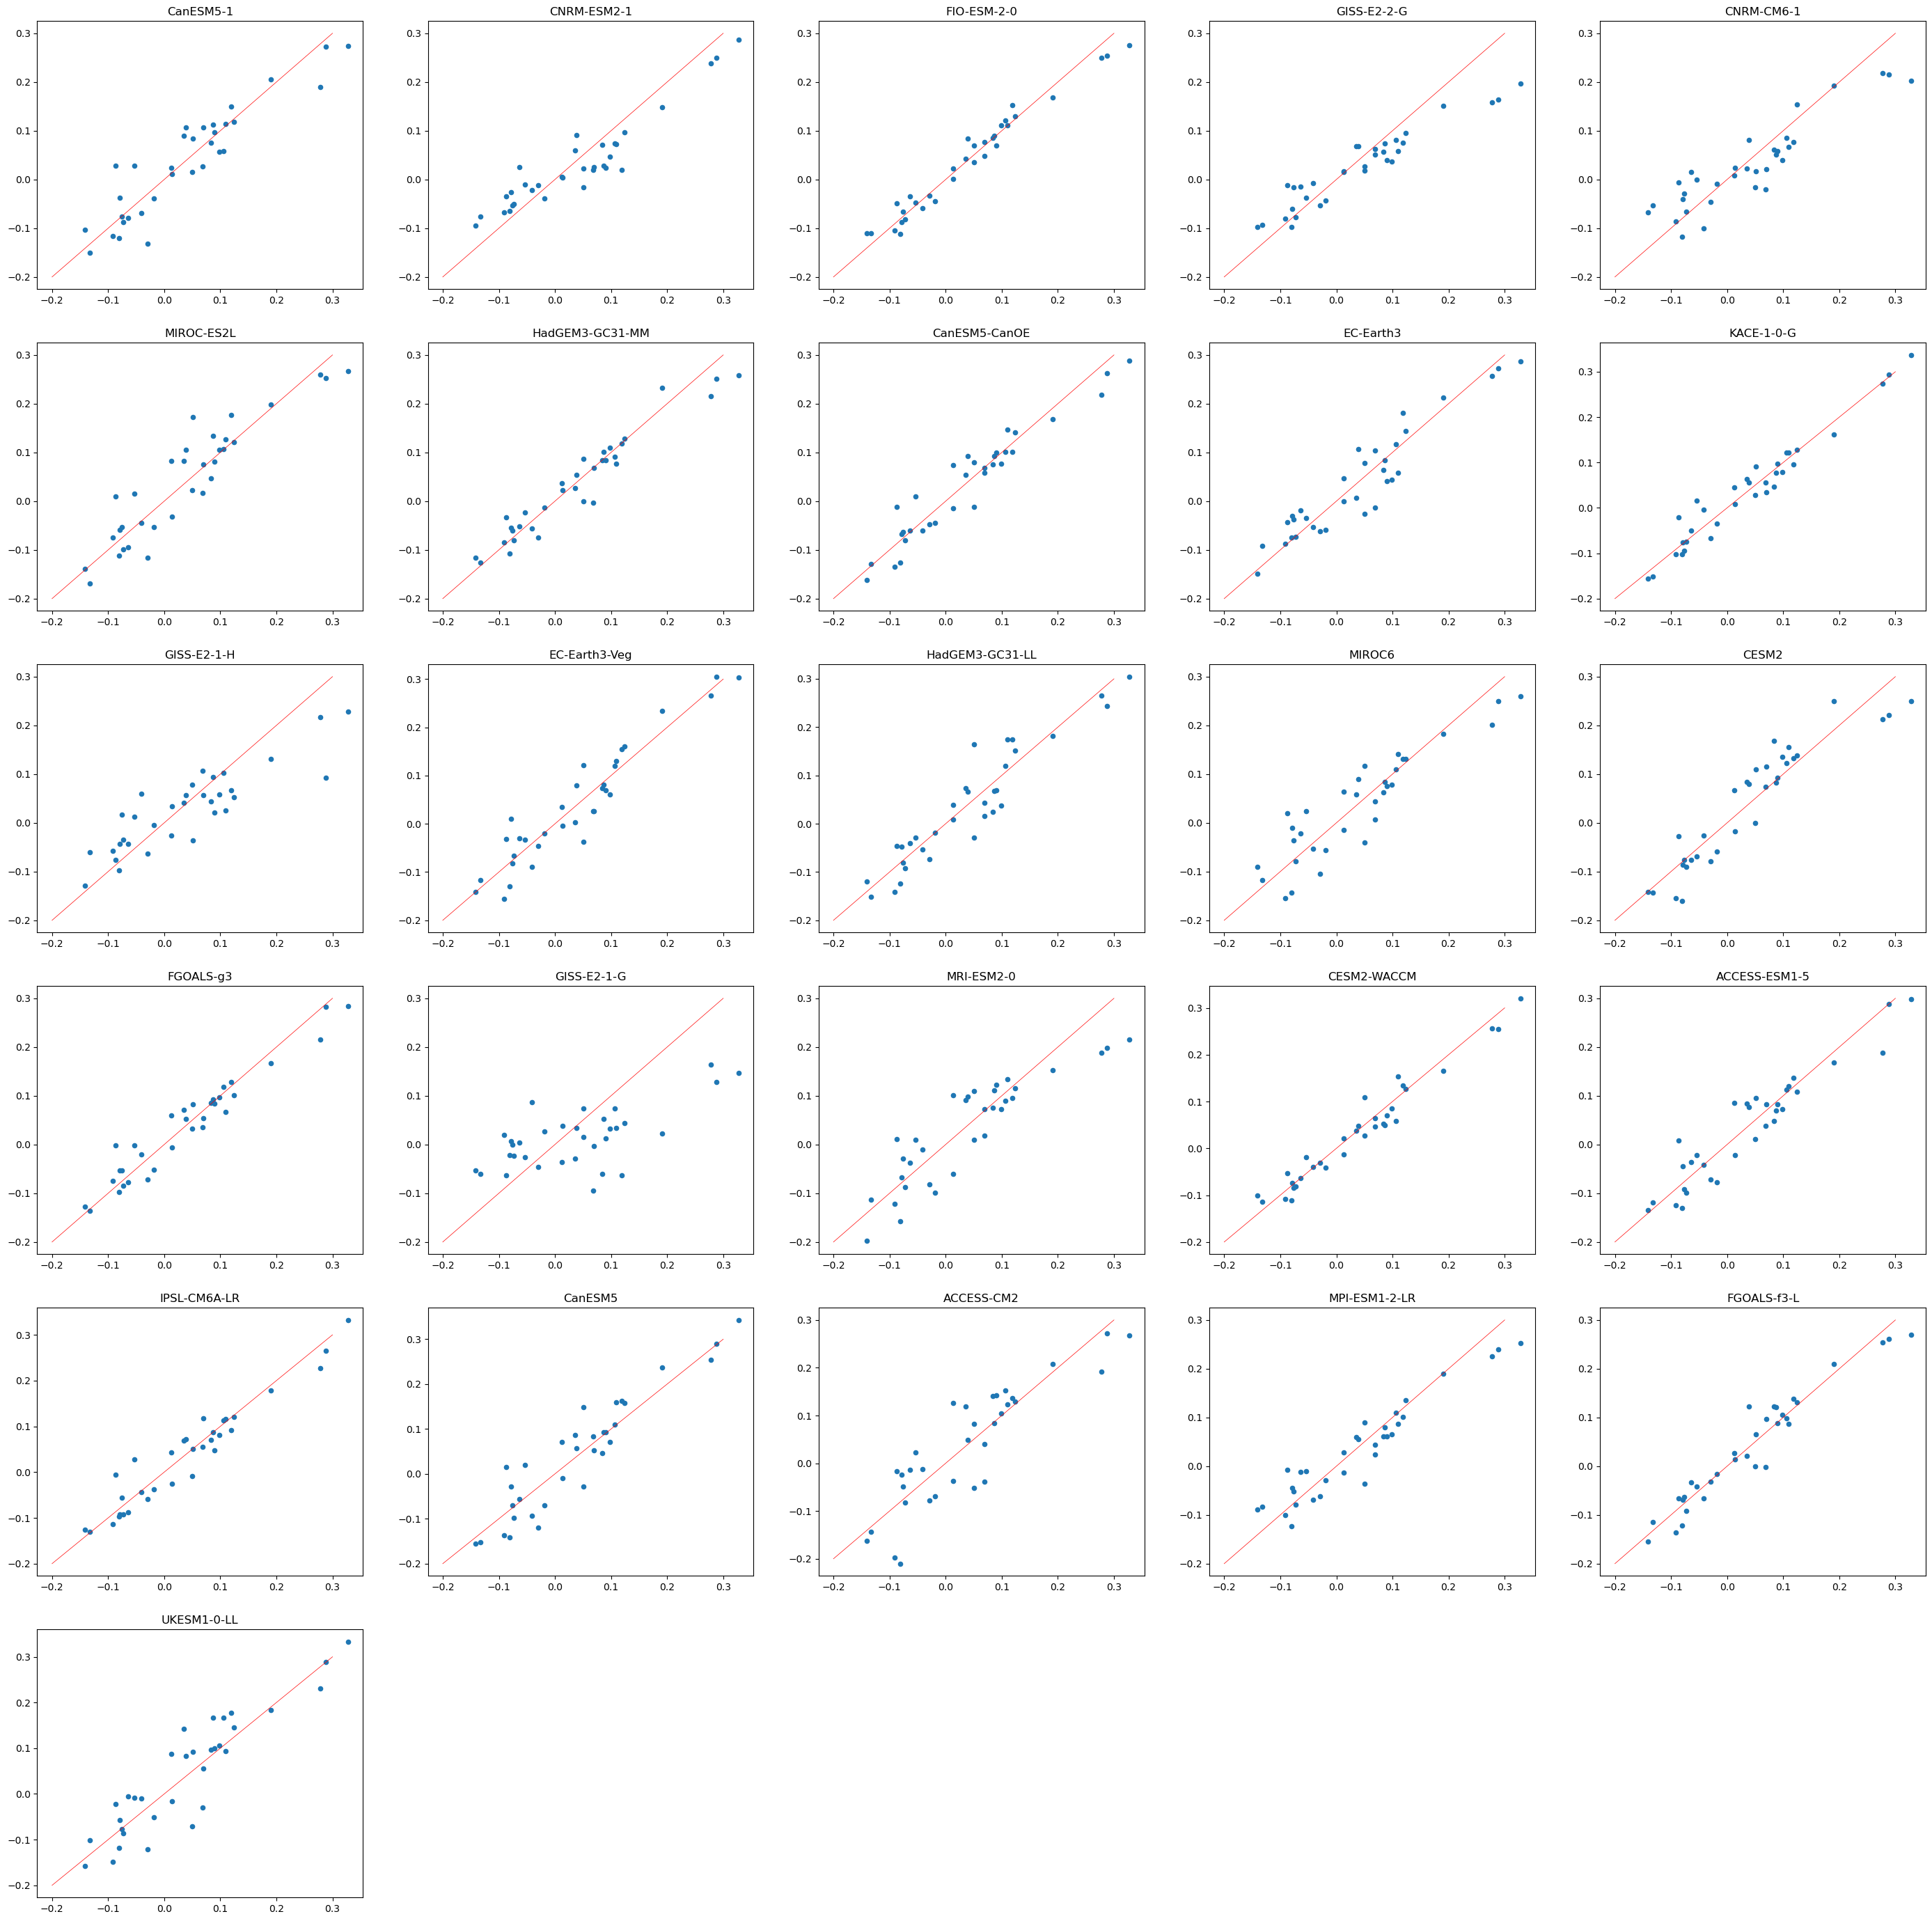

In [42]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(6,5, figsize=(35,35), facecolor='w', edgecolor='k')
axs = axs.ravel()
    
for idx_m, m in enumerate(x_predictor.keys()):
    axs[idx_m].scatter(ytrue,ypred[m],label=m,s=20.0)
    axs[idx_m].plot(np.linspace(-0.2,0.3,10),np.linspace(-0.2,0.3,10),color='r',linewidth=0.5)
    axs[idx_m].set_title(m)

for i in range(len(x_predictor.keys()),30):
    fig.delaxes(axs[i])
    
plt.savefig("Residuals.png")
plt.show()

# Analysis of the $\beta$

#### 1) PCA on the betas

In [15]:
for idx_m,m in enumerate(betas.keys()):
    beta_mean[m] = {}
    for idx_lambda,lambda_ in enumerate(betas[m].keys()):
        
        beta_mean[m][lambda_] = np.mean(list(betas[m][lambda_].values()),axis=0) 



In [17]:
# beta_mean = {}
# for idx_m,m in enumerate(betas.keys()):
#     beta_mean[m] = {}
#     for idx_beta,beta in enumerate(betas[m].keys()):
#         beta_mean[m][beta] = np.zeros((lat.shape[0]*lon.shape[0]))
#         for idx_i, i in enumerate(betas[m][beta].keys()):
#             beta_mean[m][beta] += np.array(list(betas[m][beta][i]))
#         beta_mean[m][beta] = beta_mean[m][beta]/len(betas[m][beta].keys())

In [119]:
best_rmse = {}
for idx_m,m in enumerate(rmse.keys()):
    best_rmse[m] = {}
    for idx_beta,beta in enumerate(betas[m].keys()):
        best_rmse[m][beta] = 0
        for idx_i, i in enumerate(betas[m][beta].keys()):
            best_rmse[m][beta] += rmse[m][beta][i]
        best_rmse[m][beta] = best_rmse[m][beta]/len(betas[m][beta].keys())

{0.01: tensor(0.0415, dtype=torch.float64), 0.05: tensor(0.0406, dtype=torch.float64), 0.1: tensor(0.0404, dtype=torch.float64), 0.5: tensor(0.0403, dtype=torch.float64), 1.0: tensor(0.0405, dtype=torch.float64), 5.0: tensor(0.0442, dtype=torch.float64), 10.0: tensor(0.0493, dtype=torch.float64), 50.0: tensor(0.0840, dtype=torch.float64), 100.0: tensor(0.1099, dtype=torch.float64), 500.0: tensor(0.1632, dtype=torch.float64), 1000.0: tensor(0.1755, dtype=torch.float64), 5000.0: tensor(0.1872, dtype=torch.float64)}
{0.01: tensor(0.0530, dtype=torch.float64), 0.05: tensor(0.0507, dtype=torch.float64), 0.1: tensor(0.0498, dtype=torch.float64), 0.5: tensor(0.0495, dtype=torch.float64), 1.0: tensor(0.0500, dtype=torch.float64), 5.0: tensor(0.0554, dtype=torch.float64), 10.0: tensor(0.0616, dtype=torch.float64), 50.0: tensor(0.0806, dtype=torch.float64), 100.0: tensor(0.0877, dtype=torch.float64), 500.0: tensor(0.0979, dtype=torch.float64), 1000.0: tensor(0.0999, dtype=torch.float64), 5000.0:

In [120]:
best_rmse

{'CanESM5-1': {0.01: tensor(0.0415, dtype=torch.float64),
  0.05: tensor(0.0406, dtype=torch.float64),
  0.1: tensor(0.0404, dtype=torch.float64),
  0.5: tensor(0.0403, dtype=torch.float64),
  1.0: tensor(0.0405, dtype=torch.float64),
  5.0: tensor(0.0442, dtype=torch.float64),
  10.0: tensor(0.0493, dtype=torch.float64),
  50.0: tensor(0.0840, dtype=torch.float64),
  100.0: tensor(0.1099, dtype=torch.float64),
  500.0: tensor(0.1632, dtype=torch.float64),
  1000.0: tensor(0.1755, dtype=torch.float64),
  5000.0: tensor(0.1872, dtype=torch.float64)},
 'CNRM-ESM2-1': {0.01: tensor(0.0530, dtype=torch.float64),
  0.05: tensor(0.0507, dtype=torch.float64),
  0.1: tensor(0.0498, dtype=torch.float64),
  0.5: tensor(0.0495, dtype=torch.float64),
  1.0: tensor(0.0500, dtype=torch.float64),
  5.0: tensor(0.0554, dtype=torch.float64),
  10.0: tensor(0.0616, dtype=torch.float64),
  50.0: tensor(0.0806, dtype=torch.float64),
  100.0: tensor(0.0877, dtype=torch.float64),
  500.0: tensor(0.0979, dty

In [19]:
best_lambda = {}
for idx_m,m in enumerate(rmse.keys()):
    best_lambda[m] = min(best_rmse[m], key=best_rmse[m].get)

In [20]:
best_beta = {}
for idx_m,m in enumerate(rmse.keys()):
    best_beta[m] = beta_mean[m][best_lambda[m]]

In [21]:
best_beta_tmp = torch.from_numpy(np.array(list(best_beta.values())))

# Run PCA on the Betas

In [77]:
import torch

# run with PCA with pytorch
U,S,V = torch.pca_lowrank(best_beta_tmp, q=26, center=True, niter=10)
proj_first_comp = torch.matmul(best_beta_tmp, V[:, :])
eigs = S**2

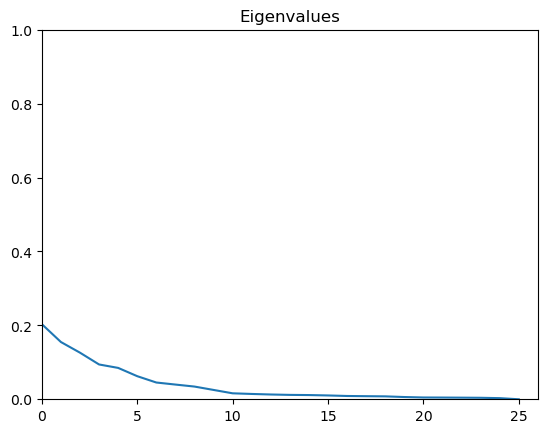

In [87]:
fig = plt.figure()
plt.plot(eigs / torch.sum(eigs))
plt.ylim((0.0,1.0))
plt.xlim((0.0,26))
plt.title('Eigenvalues')
plt.savefig("eigenvalues.png")
plt.show()

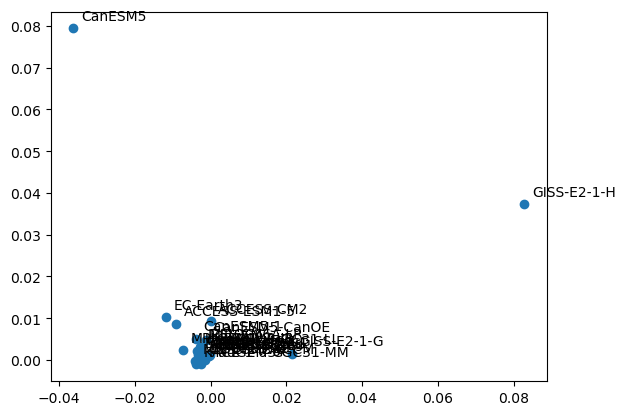

In [89]:
comp_x = 0
comp_y = 1

fig, ax = plt.subplots()
ax.scatter(proj_first_comp[:,comp_x],proj_first_comp[:,comp_y])

for idx_m, m in enumerate(dic_reduced_ssp585.keys()):
    ax.annotate(m, (proj_first_comp[idx_m,comp_x]+.002, proj_first_comp[idx_m,comp_y]+.002))

plt.savefig("projected_component_"+ str(comp_x)+ "_"+ str(comp_y)+".png")
plt.show()

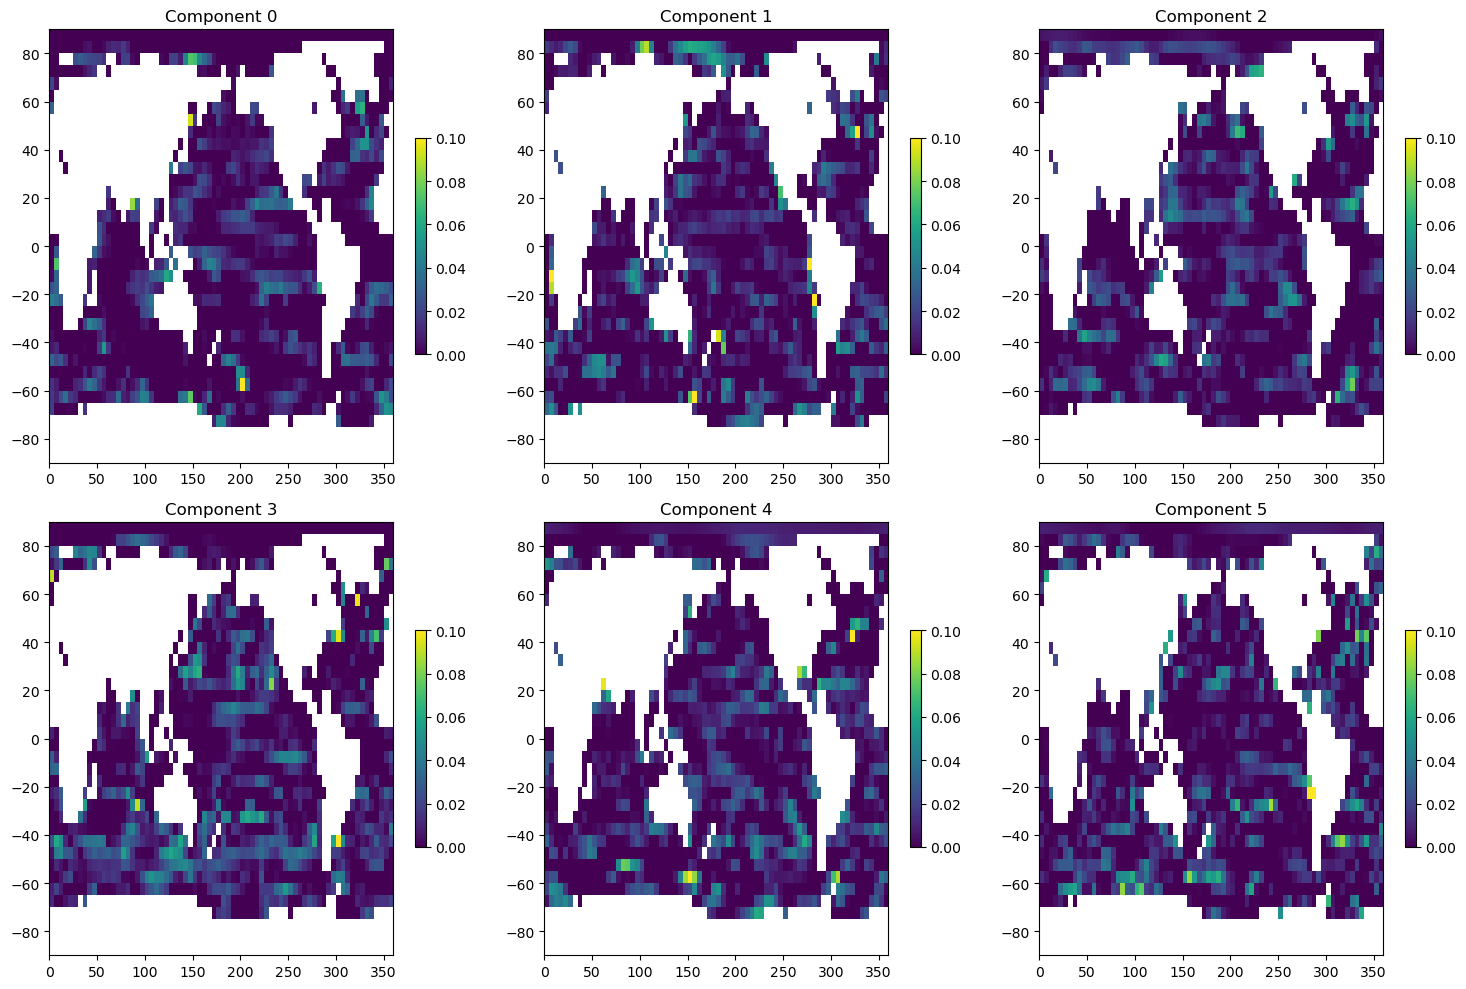

In [49]:
# plot the beta map of each mode
fig, axs = plt.subplots(2,3, figsize=(15,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 2.0, wspace=1.0)

axs = axs.ravel()
    
for k in range(6):
        
    beta_tmp = V[:,k].detach().clone()
    beta_tmp[nan_idx] = float('nan')
    beta_tmp = beta_tmp.detach().numpy().reshape(grid_lat_size,grid_lon_size)

    axs[k].set_title('Component '+ str(k))
    im0 = axs[k].pcolormesh(lon_grid,lat_grid,beta_tmp,vmin=-0.00,vmax = 0.1)

    plt.colorbar(im0, ax=axs[k], shrink=0.5)

fig.tight_layout()
plt.savefig("principal_directions.png")
plt.show()

## 2) Hierarchical clustering

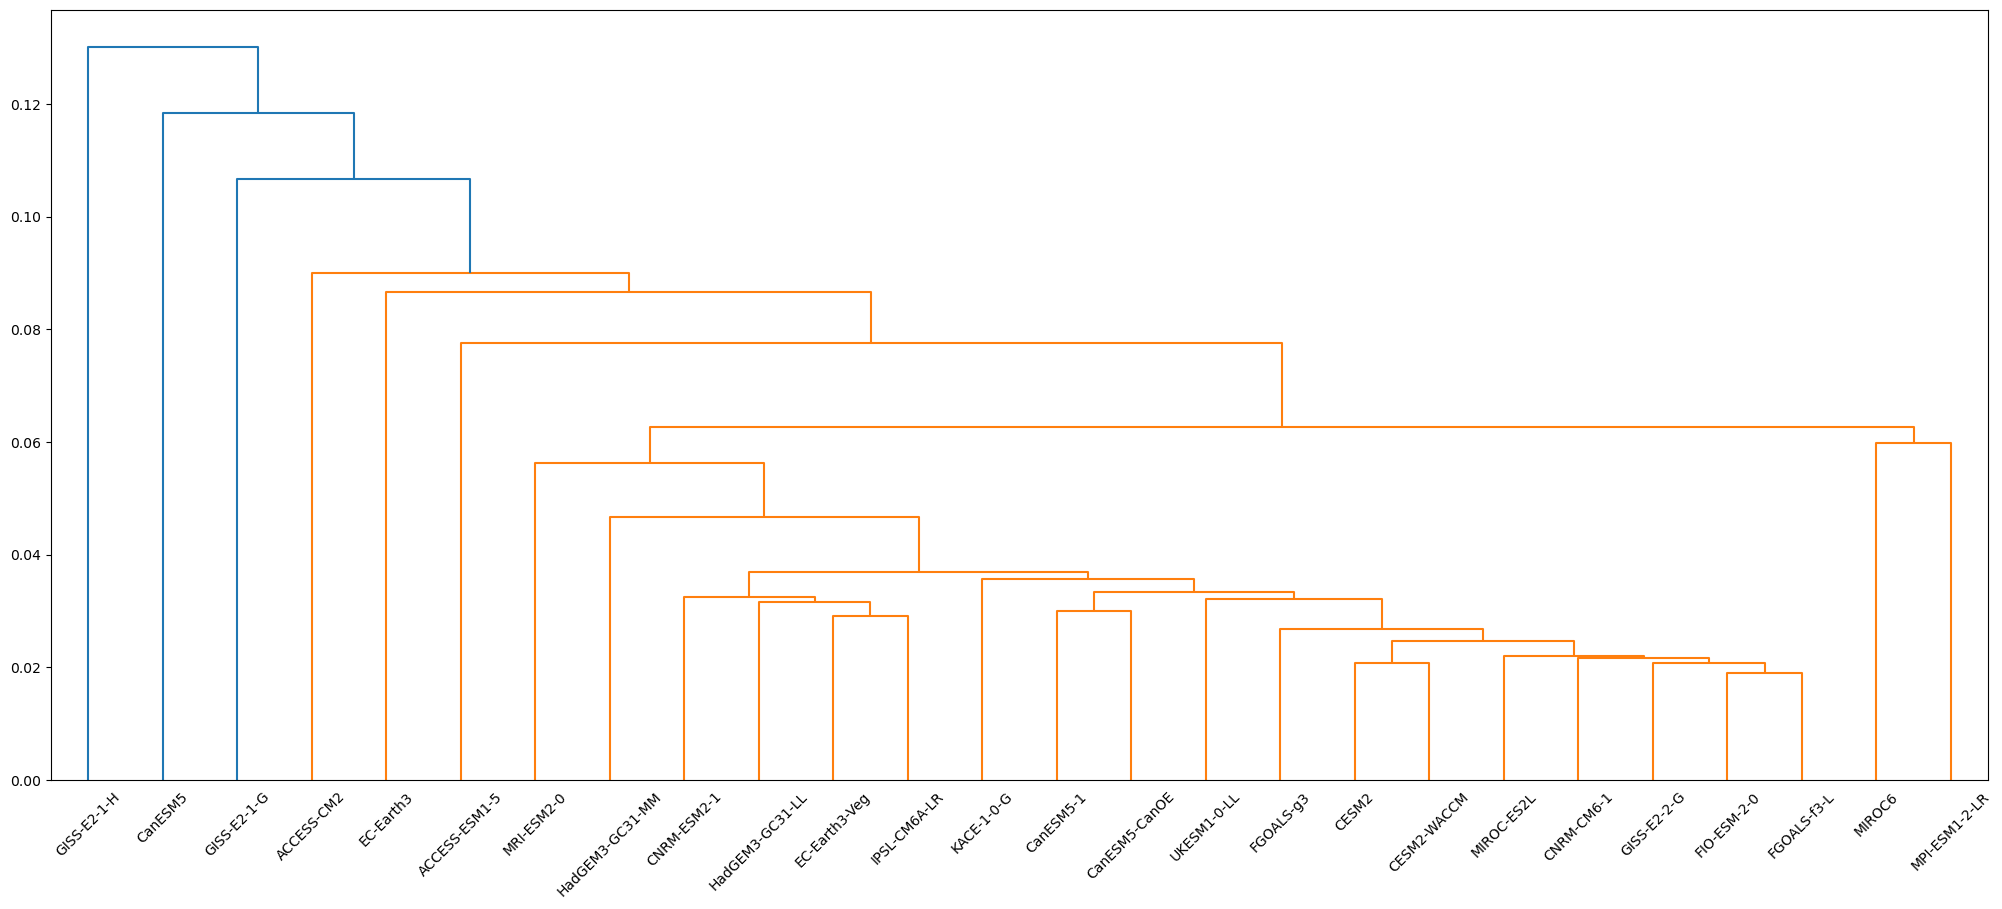

In [38]:
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list

models = list(dic_reduced_ssp585.keys())
Z1 = linkage(best_beta_tmp, 'ward')
leaves_tmp = leaves_list(Z1)

labels_tmp =  [models[int(i)] for i in leaves_tmp] 


fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z1,labels = models)
plt.savefig("hierarchical_clustering.png")

# Plot the betas according to a given ordering

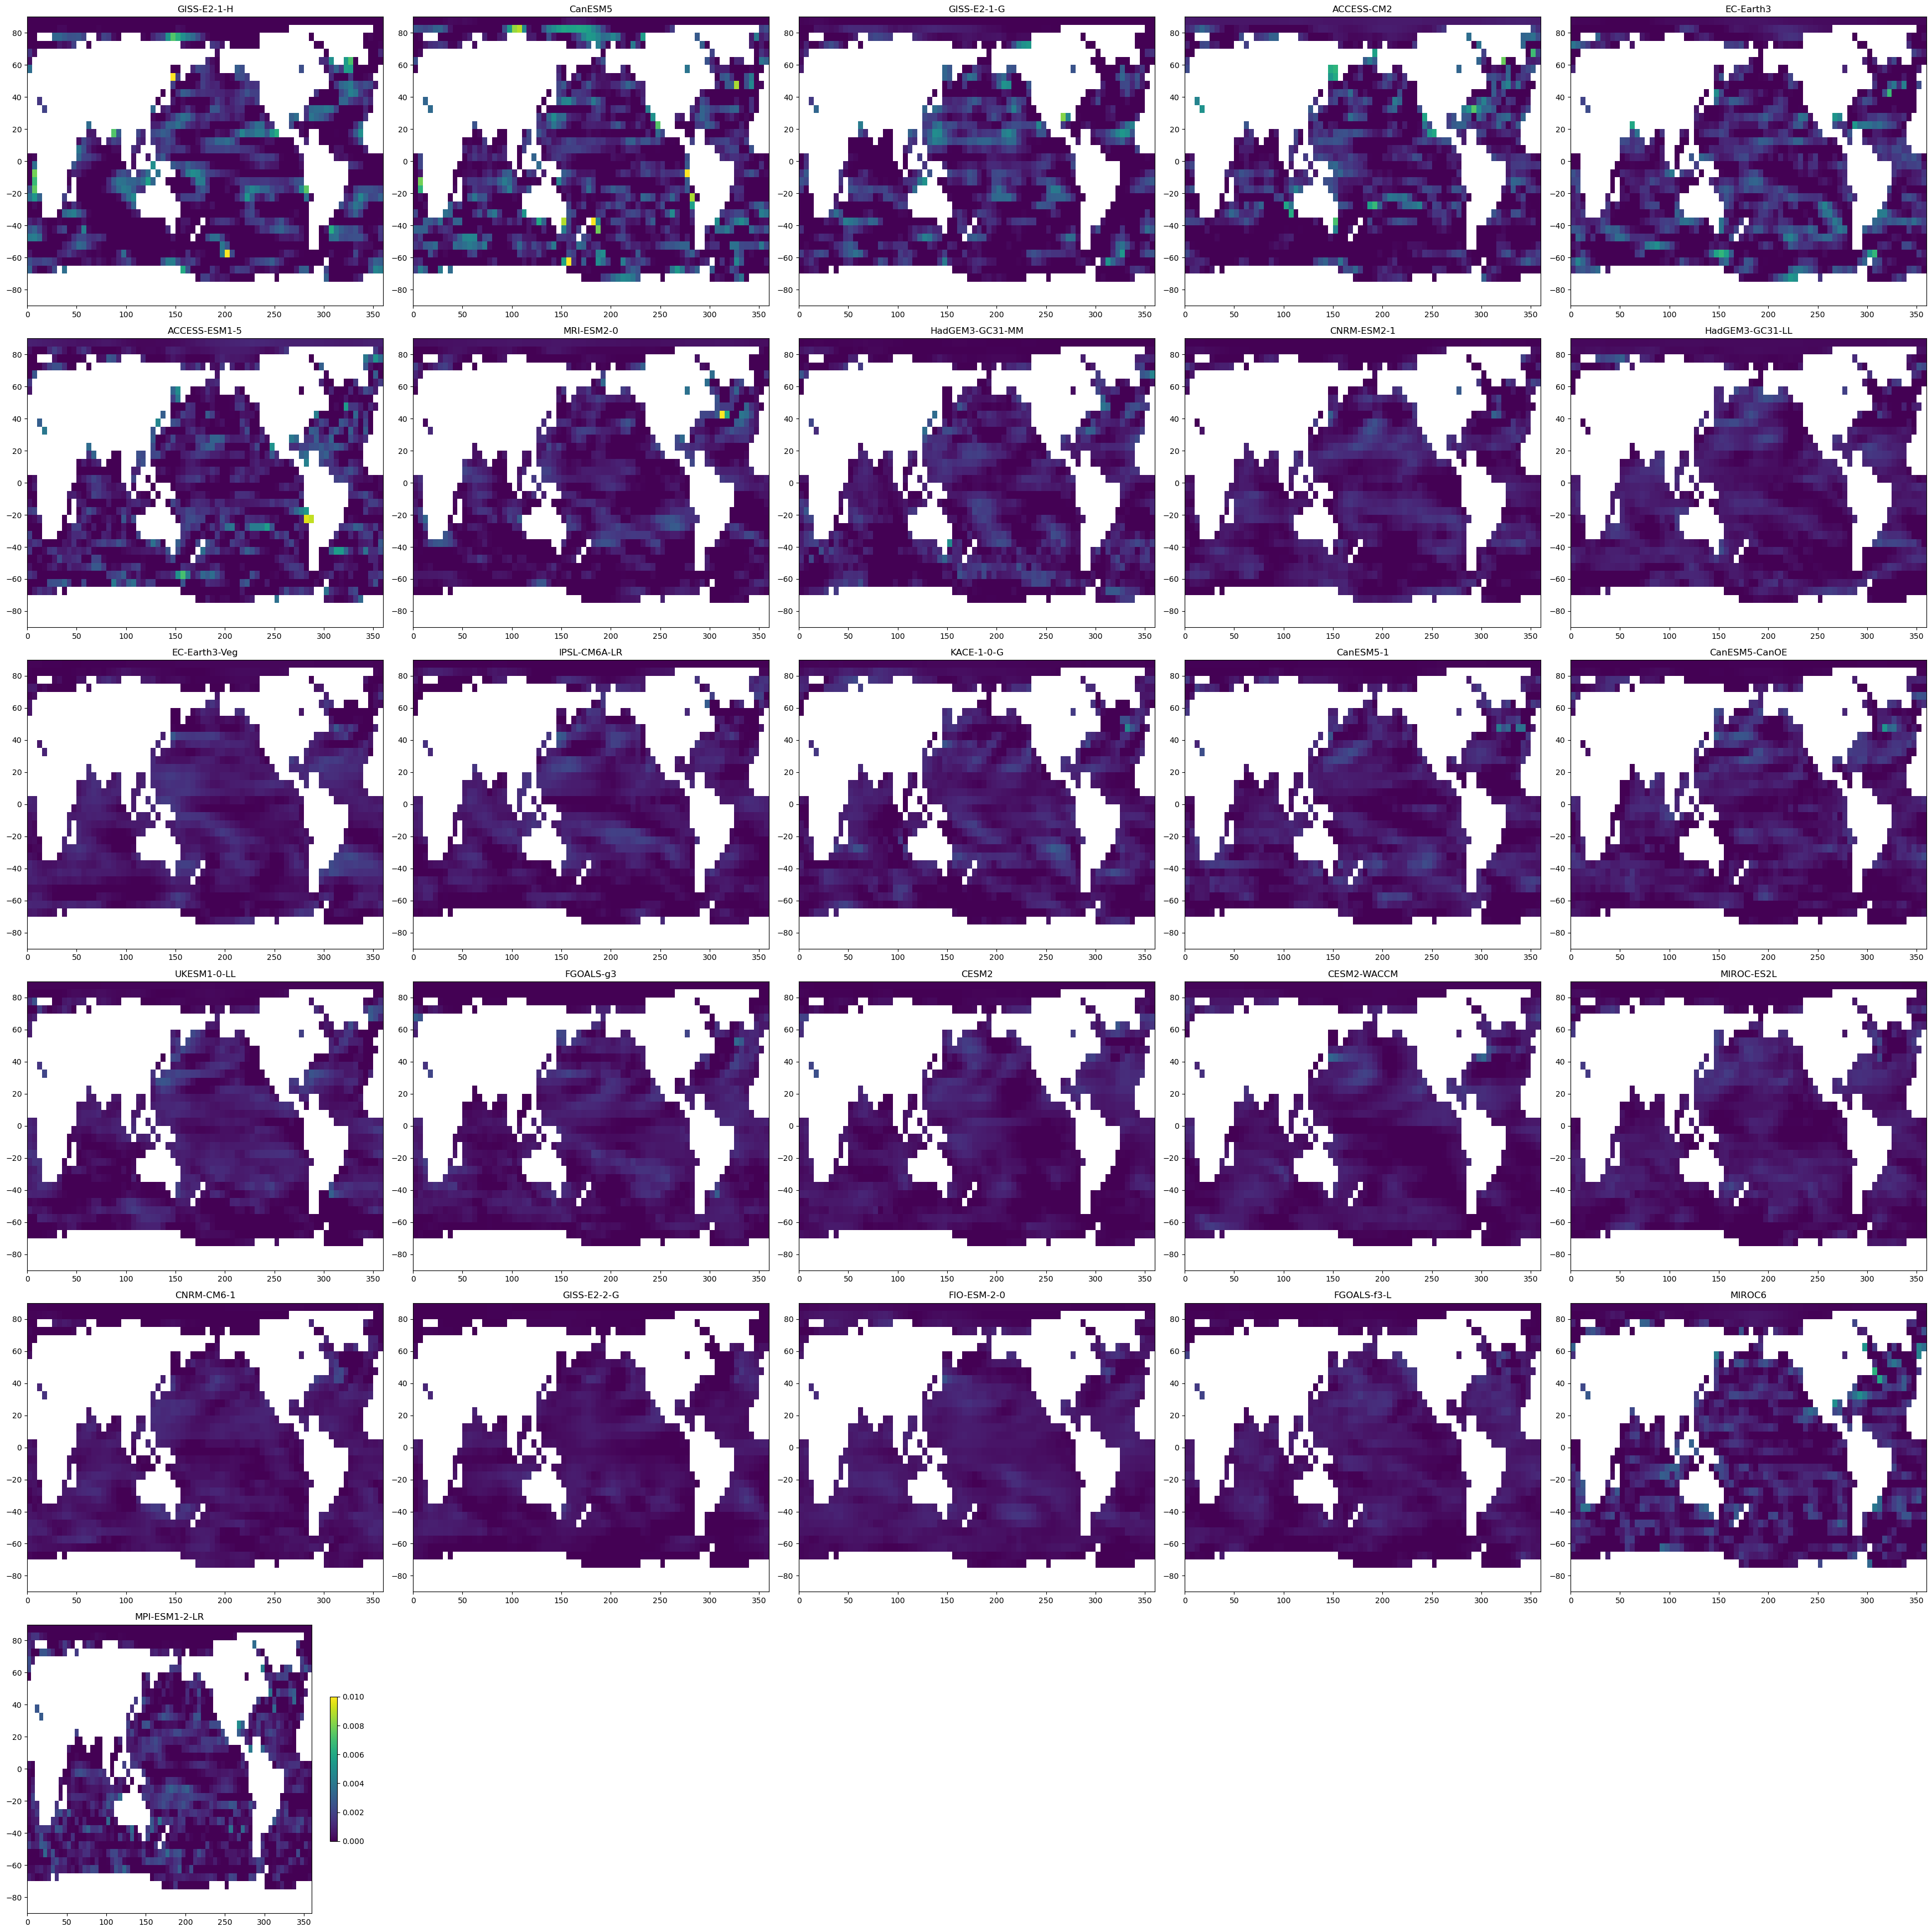

In [88]:
# plot the beta maps in the leaf-based ordering
fig, axs = plt.subplots(6,5, figsize=(35,35), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 2.0, wspace=1.0)

axs = axs.ravel()
    
for idx,i in enumerate(dn['leaves']):

    m = models[int(i)] 
    beta_tmp = best_beta_tmp[int(i),:].detach().clone()
    beta_tmp[nan_idx] = float('nan')
    beta_tmp = beta_tmp.detach().numpy().reshape(grid_lat_size,grid_lon_size)

    axs[idx].set_title(m)
    im0 = axs[idx].pcolormesh(lon_grid,lat_grid,beta_tmp,vmin=-0.00,vmax = 0.01)

plt.colorbar(im0, ax=axs[idx], shrink=0.5)

for i in range(len(dic_reduced_ssp585.keys()),30):
    fig.delaxes(axs[i])

fig.tight_layout()
plt.savefig('betas_map.png')
plt.show()

# Run PCA without the first models

In [102]:
best_beta_bis = {}
reduced_model = []
for idx_m,m in enumerate(rmse.keys()):
    if (m != 'GISS-E2-1-H') and (m != 'CanESM5'):
        reduced_model.append(m)
        best_beta_bis[m] = beta_mean[m][best_lambda[m]]

best_beta_bis_tmp = torch.from_numpy(np.array(list(best_beta_bis.values())))

In [103]:
# run with PCA with pytorch
U,S,V = torch.pca_lowrank(best_beta_bis_tmp, q=24, center=True, niter=10)
proj_first_comp = torch.matmul(best_beta_bis_tmp, V[:, :])
eigs = S**2

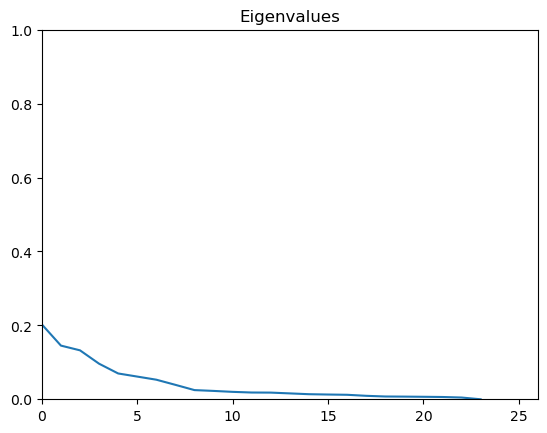

In [104]:
fig = plt.figure()
plt.plot(eigs / torch.sum(eigs))
plt.ylim((0.0,1.0))
plt.xlim((0.0,26))
plt.title('Eigenvalues')
plt.savefig("eigenvalues.png")
plt.show()

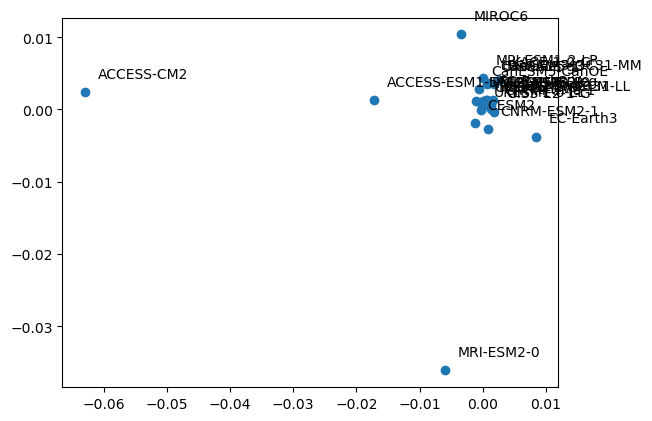

In [112]:
comp_x = 1
comp_y = 6

fig, ax = plt.subplots()
ax.scatter(proj_first_comp[:,comp_x],proj_first_comp[:,comp_y])

for idx_m, m in enumerate(reduced_model):
    ax.annotate(m, (proj_first_comp[idx_m,comp_x]+.002, proj_first_comp[idx_m,comp_y]+.002))

plt.savefig("projected_component_bis_"+ str(comp_x)+ "_"+ str(comp_y)+".png")
plt.show()

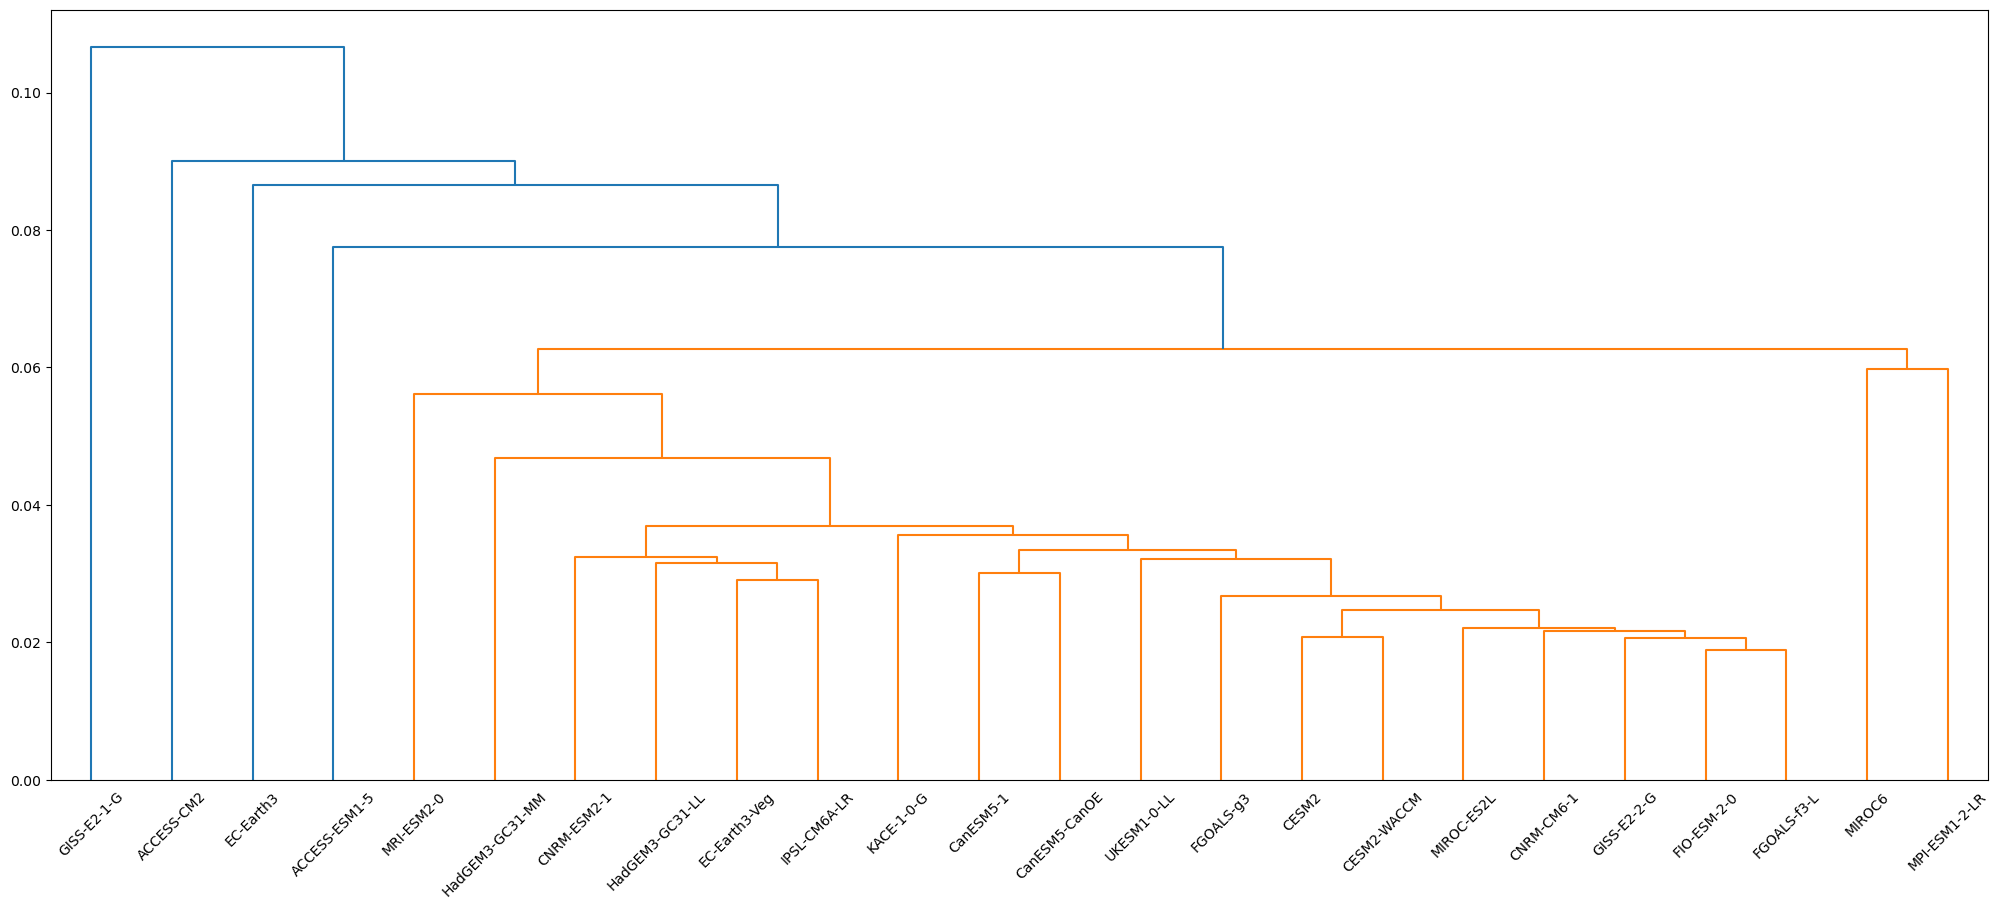

In [114]:
Z1 = linkage(best_beta_bis_tmp, 'ward')
leaves_tmp = leaves_list(Z1)

labels_tmp =  [reduced_model[int(i)] for i in leaves_tmp] 


fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z1,labels = reduced_model)
plt.savefig("hierarchical_clustering_bis.png")

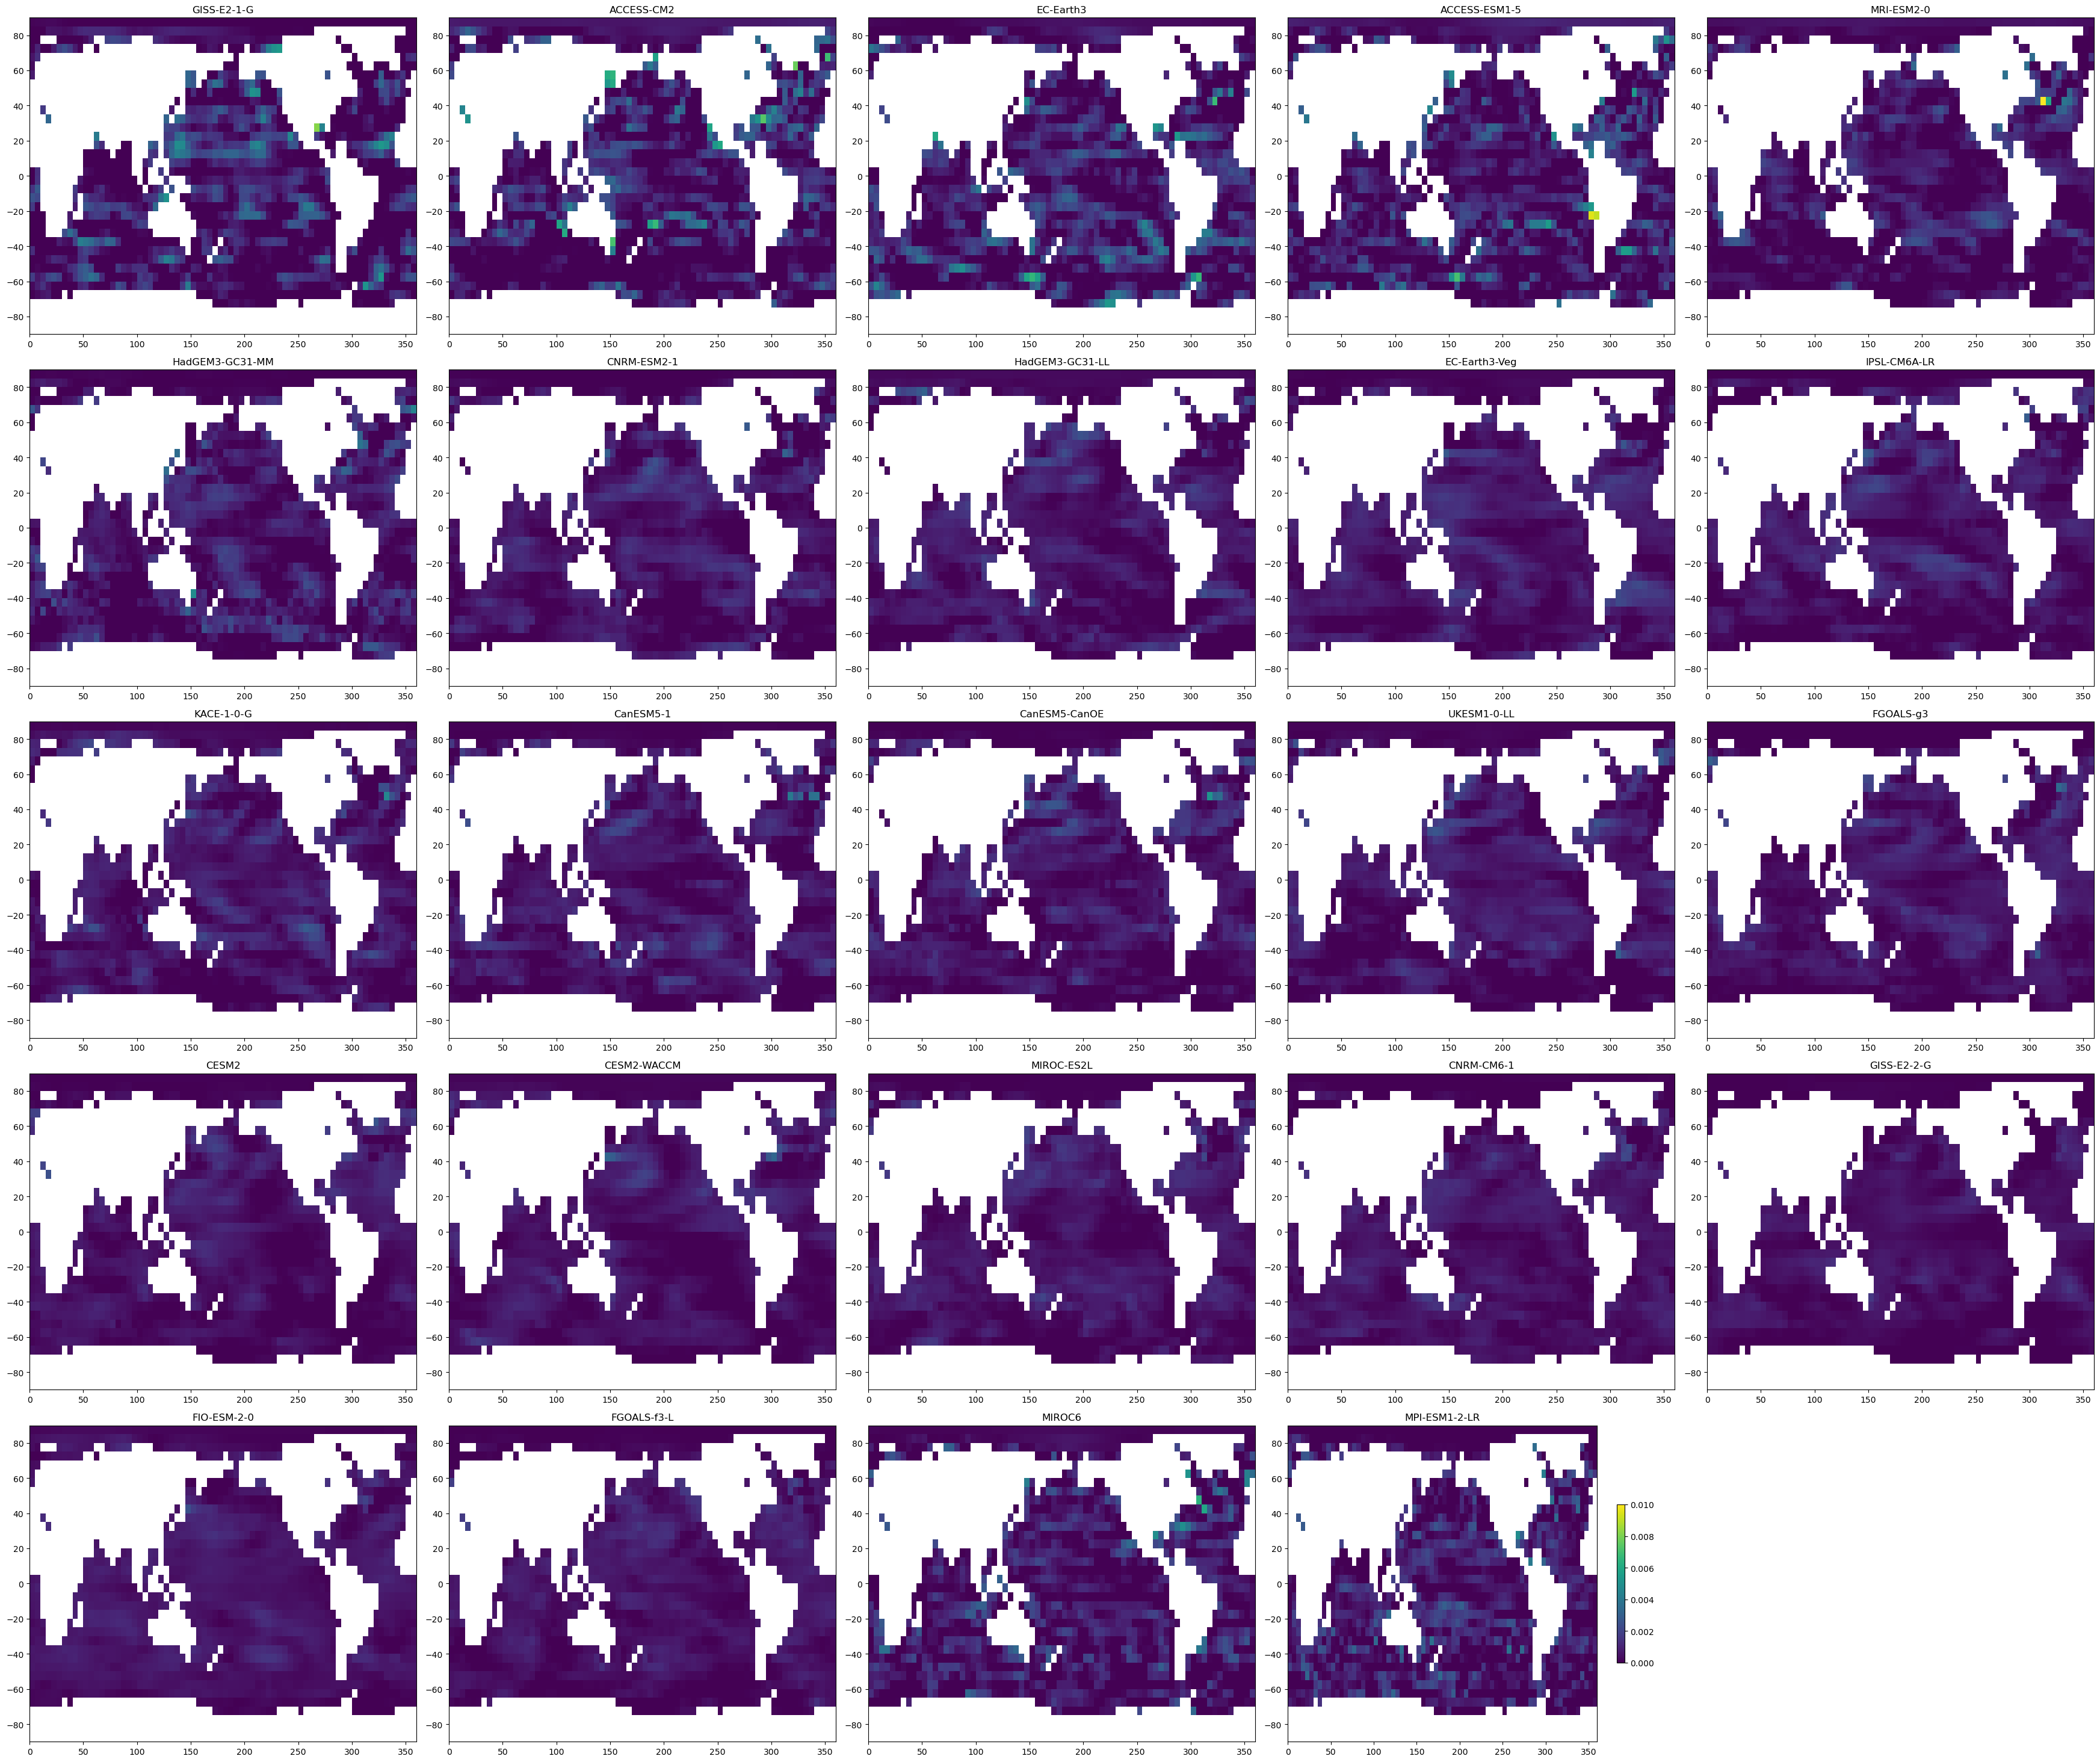

In [117]:
# plot the beta maps in the leaf-based ordering
fig, axs = plt.subplots(6,5, figsize=(35,35), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 2.0, wspace=1.0)

axs = axs.ravel()
    
for idx,i in enumerate(dn['leaves']):

    m = reduced_model[int(i)] 
    beta_tmp = best_beta_bis_tmp[int(i),:].detach().clone()
    beta_tmp[nan_idx] = float('nan')
    beta_tmp = beta_tmp.detach().numpy().reshape(grid_lat_size,grid_lon_size)

    axs[idx].set_title(m)
    im0 = axs[idx].pcolormesh(lon_grid,lat_grid,beta_tmp,vmin=-0.00,vmax = 0.01)

plt.colorbar(im0, ax=axs[idx], shrink=0.5)

for i in range(len(reduced_model),30):
    fig.delaxes(axs[i])

fig.tight_layout()
plt.savefig('betas_map.png')
plt.show()